# Case Study III: Liquidity Risk Modeling With GMMs

Liquidity is an important source of risk in financial markets. The importance of liquidity has been highlighted and has gained much attention since the global mortgage crisis broke out in 2007–2008. During this crisis, most financial institutions were hit hard by liquidity pressures, resulting in several strict measures taken by regulatory authorities and central banks. Since then, debates over the need to include liquidity, originating from the lack of tradable securities, have intensified.

* **Tightness**
The ability to trade an asset at the same price at the same time. This refers to the transaction cost occurring during a trade. If the transaction cost is high, the difference between buy and sell prices will be high or vice versa. So, a narrow transaction cost defines how tight the market is.

* **Immediacy**
The speed at which a large amount of buy or sell orders can be traded. This dimension of liquidity provides us with valuable information about the financial market, as low immediacy refers to malfunctioning of parts of the market such as clearing, settlement, and so forth.

* **Depth**
The presence of large numbers of buyers and sellers who are able to cover abundant orders at various prices.

* **Resiliency**
A market’s ability to bounce back from nonequilibrium. It can be thought of as a price-recovery process in which order imbalance dies out quickly.

As you can see, the concept of liquidity is multifaceted. Therfoer, we will employ the following four family of quantitative measures to provide a more comprehensive representation of liquidity:

* *Volume*
* *Transaction cost*
* *Price impact*
* *Market impact*

## 0. Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('use_inf_as_na', True)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
from google.colab import drive

drive.mount('/content/drive')

%cd "drive/MyDrive/405_ML_Applications/"

Mounted at /content/drive
/content/drive/MyDrive/405_ML_Applications


## Import and preprocesss data

Let’s first import the data and observe it via the following code blocks. As it is readily observable, the main variables in the dataset are ask (ASKHI), bid (BIDLO), open (OPENPRC), and trading price (PRC) along with the volume (VOL), return (RET), volume-weighted return (vwretx) of the stock, and number of shares outstanding (SHROUT):

In [3]:
liq_data = pd.read_csv('data/bid_ask.csv')

In [6]:
liq_data.head(7)

Unnamed: 0        Date  EXCHCD TICKER      COMNAM  BIDLO   ASKHI    PRC  \
0     1031570  2019-01-02     3.0   INTC  INTEL CORP  45.77  47.470  47.08   
1     1031571  2019-01-03     3.0   INTC  INTEL CORP  44.39  46.280  44.49   
2     1031572  2019-01-04     3.0   INTC  INTEL CORP  45.54  47.570  47.22   
3     1031573  2019-01-07     3.0   INTC  INTEL CORP  46.75  47.995  47.44   
4     1031574  2019-01-08     3.0   INTC  INTEL CORP  46.78  48.030  47.74   
5     1031575  2019-01-09     3.0   INTC  INTEL CORP  47.78  48.570  48.01   
6     1031576  2019-01-10     3.0   INTC  INTEL CORP  47.41  48.650  48.56   

          VOL       RET     SHROUT  OPENPRC    vwretx  
0  18761673.0  0.003196  4564000.0   45.960  0.001783  
1  32254097.0 -0.055013  4564000.0   46.150 -0.021219  
2  35419836.0  0.061362  4564000.0   45.835  0.033399  
3  22724997.0  0.004659  4564000.0   47.100  0.009191  
4  22721240.0  0.006324  4564000.0   47.800  0.010240  
5  22545591.0  0.005656  4564000.0   47.960  0.005952  
6  27185675.0  0.011456  4564000.0   47.750  0.004468

In [7]:
liq_data.shape

(756, 13)

Calculating some liquidity measures requires a rolling-window estimation, such as the calculation of the bid price for five days. To accomplish this task, the list named rolling_five is generated using the following code:

In [8]:
# all of the following measures and cols we add before the cluster analysis
# are not the main point of this notebook and hence not explained very well.

# if you're interested in them there is always the option to google/look them up.


rolling_five = []

for j in liq_data.TICKER.unique():
    for i in range(len(liq_data[liq_data.TICKER == j])):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO': 'min',
                                                'ASKHI': 'max',
                                                 'VOL': 'sum',
                                                 'SHROUT': 'mean',
                                                 'PRC': 'mean'}))

In [9]:
rolling_five_df = pd.DataFrame(rolling_five)
rolling_five_df.columns = ['bidlo_min', 'askhi_max', 'vol_sum',
                           'shrout_mean', 'prc_mean']
liq_vol_all = pd.concat([liq_data,rolling_five_df], axis=1)

liq_vol_all.head()

Unnamed: 0        Date  EXCHCD TICKER      COMNAM  BIDLO   ASKHI    PRC  \
0     1031570  2019-01-02     3.0   INTC  INTEL CORP  45.77  47.470  47.08   
1     1031571  2019-01-03     3.0   INTC  INTEL CORP  44.39  46.280  44.49   
2     1031572  2019-01-04     3.0   INTC  INTEL CORP  45.54  47.570  47.22   
3     1031573  2019-01-07     3.0   INTC  INTEL CORP  46.75  47.995  47.44   
4     1031574  2019-01-08     3.0   INTC  INTEL CORP  46.78  48.030  47.74   

          VOL       RET     SHROUT  OPENPRC    vwretx  bidlo_min  askhi_max  \
0  18761673.0  0.003196  4564000.0   45.960  0.001783      44.39     48.030   
1  32254097.0 -0.055013  4564000.0   46.150 -0.021219      44.39     48.570   
2  35419836.0  0.061362  4564000.0   45.835  0.033399      45.54     48.650   
3  22724997.0  0.004659  4564000.0   47.100  0.009191      46.75     49.291   
4  22721240.0  0.006324  4564000.0   47.800  0.010240      46.78     49.291   

       vol_sum  shrout_mean  prc_mean  
0  131881843.0    4564000.0    46.794  
1  135665761.0    4564000.0    46.980  
2  130597339.0    4564000.0    47.794  
3  116906594.0    4564000.0    48.136  
4  113367907.0    4564000.0    48.318

## Volume Based Measure

Large orders are covered when the market has depth, that is, a deep financial market has the ability to meet abundant orders. This, in turn, provides information about the market, and if the market lacks depth, order imbalance and discontinuity emerge in the market. Given the market’s depth, volume-based liquidity measures can be used to distinguish liquid and illiquid assets. Moreover, volume-based liquidity measures have a strong association with bid-ask spread: a large bid-ask spread implies low volume, while a narrow bid-ask spread implies high volume.

To properly represent the depth dimension of liquidity, the following volume-based measures will be introduced:

* Liquidity ratio
* Hui-Heubel ratio
* Turnover ratio

In [10]:
liq_ratio = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        liq_ratio.append((liq_vol_all['PRC'][i+1:i+6] * 
                          liq_vol_all['VOL'][i+1:i+6]).sum()/
                         (np.abs(liq_vol_all['PRC'][i+1:i+6].mean() - 
                                 liq_vol_all['PRC'][i:i+5].mean())))

In [11]:
Lhh = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        Lhh.append((liq_vol_all['PRC'][i:i+5].max() - 
                    liq_vol_all['PRC'][i:i+5].min()) /  
                   liq_vol_all['PRC'][i:i+5].min() /  
                   (liq_vol_all['VOL'][i:i+5].sum() / 
                    liq_vol_all['SHROUT'][i:i+5].mean() * 
                    liq_vol_all['PRC'][i:i+5].mean()))

In [12]:
turnover_ratio = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        turnover_ratio.append((1/liq_vol_all['VOL'].count()) * 
                              (np.sum(liq_vol_all['VOL'][i:i+1]) / 
                               np.sum(liq_vol_all['SHROUT'][i:i+1])))

In [13]:
liq_vol_all['liq_ratio'] = pd.DataFrame(liq_ratio)
liq_vol_all['Lhh'] = pd.DataFrame(Lhh)
liq_vol_all['turnover_ratio'] = pd.DataFrame(turnover_ratio)

## Transaction Cost Based Measures

Transaction cost is a cost an investor must bear during trade. It is referred to as any expenses related to the execution of trade. A distinction of transaction cost as explicit and implicit costs is possible. The former relates to order processing, taxes, and brokerage fees, while the latter includes more latent costs, such as bid-ask spread, timing of execution, and so on.

Transaction cost is related to the tightness and immediacy dimensions of liquidity. High transaction costs discourage investors to trade and this, in turn, decreases the number of buyers and sellers in the market so that the trading place diverges away from the more centralized market into a fragmented one, which result in a shallow market. To the extent that transaction cost is low, investors are willing to trade and this results in a flourished trading environment in which markets will be more centralized.
Similarly, an abundance of buyers and sellers in a low transaction cost environment refers to the fact that a large number of orders are traded in a short period of time. So, immediacy is the other dimension of liquidity, which is closely related to the transaction cost.

### Bid-Ask Spreads

In [14]:
liq_vol_all['mid_price'] = (liq_vol_all.ASKHI + liq_vol_all.BIDLO) / 2
liq_vol_all['percent_quoted_ba'] = (liq_vol_all.ASKHI - 
                                    liq_vol_all.BIDLO) / \
                                    liq_vol_all.mid_price
liq_vol_all['percent_effective_ba'] = 2 * abs((liq_vol_all.PRC - 
                                               liq_vol_all.mid_price)) / \
                                               liq_vol_all.mid_price

### Roll's Spread

In [15]:
liq_vol_all['price_diff'] = liq_vol_all.groupby('TICKER')['PRC']\
                            .apply(lambda x:x.diff())
liq_vol_all.dropna(inplace=True)
roll = []

for j in liq_vol_all.TICKER.unique():
     for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        roll_cov = np.cov(liq_vol_all['price_diff'][i:i+5], 
                          liq_vol_all['price_diff'][i+1:i+6])
        if roll_cov[0,1] < 0:
            roll.append(2 * np.sqrt(-roll_cov[0, 1]))
        else:
             roll.append(2 * np.sqrt(np.abs(roll_cov[0, 1])))


### Corwin and Schultz (2012)

In [16]:
gamma = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        gamma.append((max(liq_vol_all['ASKHI'].iloc[i+1], 
                          liq_vol_all['ASKHI'].iloc[i]) - 
                      min(liq_vol_all['BIDLO'].iloc[i+1], 
                          liq_vol_all['BIDLO'].iloc[i])) ** 2)
        gamma_array = np.array(gamma)

In [17]:
beta = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        beta.append((liq_vol_all['ASKHI'].iloc[i+1] - 
                     liq_vol_all['BIDLO'].iloc[i+1]) ** 2 + 
                    (liq_vol_all['ASKHI'].iloc[i] - 
                     liq_vol_all['BIDLO'].iloc[i]) ** 2)
        beta_array = np.array(beta)

In [18]:
alpha = ((np.sqrt(2 * beta_array) - np.sqrt(beta_array)) / 
       (3 - (2 * np.sqrt(2)))) - np.sqrt(gamma_array / 
                                         (3 - (2 * np.sqrt(2))))
CS_spread = (2 * np.exp(alpha - 1)) / (1 + np.exp(alpha))

In [19]:
liq_vol_all = liq_vol_all.reset_index()
liq_vol_all['roll'] = pd.DataFrame(roll)
liq_vol_all['CS_spread'] = pd.DataFrame(CS_spread)

## Price Based Measures

Price impact–based liquidity provides us measures by which we are able to gauge the extent to which price is sensitive to volume and turnover. Resiliency refers to the market responsiveness about new orders. If the market is responsive to the new order—that is, a new order corrects the imbalances in the market—then it is said to be resilient. Thus, given a change in volume and/or turnover, high price adjustment amounts to resiliency or vice versa.

We employ three price impact–based liquidity measures:

* The Amihud illiquidity measure
* The Florackis, Andros, and Alexandros (2011) price impact ratio
* Coefficient of elasticity of trading (CET)

In [20]:
dvol = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        dvol.append((liq_vol_all['PRC'][i:i+5] *
                     liq_vol_all['VOL'][i:i+5]).sum())
liq_vol_all['dvol'] = pd.DataFrame(dvol)

In [21]:
amihud = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        amihud.append((1 / liq_vol_all['RET'].count()) * 
                      (np.sum(np.abs(liq_vol_all['RET'][i:i+1])) / 
                              np.sum(liq_vol_all['dvol'][i:i+1])))

In [22]:
florackis = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        florackis.append((1 / liq_vol_all['RET'].count()) * 
                         (np.sum(np.abs(liq_vol_all['RET'][i:i+1]) / 
                                 liq_vol_all['turnover_ratio'][i:i+1])))

In [23]:
liq_vol_all['vol_diff_pct'] = liq_vol_all.groupby('TICKER')['VOL']\
                              .apply(lambda x: x.diff()).pct_change()
liq_vol_all['price_diff_pct'] = liq_vol_all.groupby('TICKER')['PRC']\
                              .apply(lambda x: x.diff()).pct_change()

In [24]:
cet = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        cet.append(np.sum(liq_vol_all['vol_diff_pct'][i:i+1])/
                   np.sum(liq_vol_all['price_diff_pct'][i:i+1]))

In [25]:
liq_vol_all['amihud'] = pd.DataFrame(amihud)
liq_vol_all['florackis'] = pd.DataFrame(florackis)
liq_vol_all['cet'] = pd.DataFrame(cet)

## Market Impact Measures

Identifying the source of information is a big deal in finance because an unknown source of information might mislead investors and lead to unintended consequences. A price surge, for instance, arising from the market does not provide the same information as one arising from an individual stock. With that being said, a new source of information should be identified in a way to capture price movement properly.

To accomplish this task, we use the capital asset pricing model (CAPM), by which we can distinguish systematic and unsystematic risk. The famous slope coefficient in CAPM indicates systematic risks, and the unsystematic risk is attributable to individual stocks as long as market risk is removed.

In [26]:
import statsmodels.api as sm

In [27]:
liq_vol_all['VOL_pct_change'] = liq_vol_all.groupby('TICKER')['VOL']\
                                .apply(lambda x: x.pct_change())
liq_vol_all.dropna(subset=['VOL_pct_change'], inplace=True)
liq_vol_all = liq_vol_all.reset_index()

In [28]:
unsys_resid = []

for i in liq_vol_all.TICKER.unique():
    X1 = liq_vol_all[liq_vol_all['TICKER'] == i]['vwretx']
    y = liq_vol_all[liq_vol_all['TICKER'] == i]['RET']
    ols = sm.OLS(y, X1).fit()
    unsys_resid.append(ols.resid)

In [29]:
market_impact = {}

for i, j in zip(liq_vol_all.TICKER.unique(), 
                range(len(liq_vol_all['TICKER'].unique()))):
    X2 = liq_vol_all[liq_vol_all['TICKER'] == i]['VOL_pct_change']
    ols = sm.OLS(unsys_resid[j] ** 2, X2).fit()
    print('***' * 30)
    print(f'OLS Result for {i}')
    print(ols.summary())
    market_impact[j] = ols.resid

******************************************************************************************
OLS Result for INTC
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.157
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              46.31
Date:                Sun, 12 Feb 2023   Prob (F-statistic):                    7.53e-11
Time:                        14:11:27   Log-Likelihood:                          1444.9
No. Observations:                 249   AIC:                                     -2888.
Df Residuals:                     248   BIC:                                     -2884.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
         

In [30]:
append1 = market_impact[0].append(market_impact[1])
liq_vol_all['market_impact'] = append1.append(market_impact[2])

These are the liquidity measures that we take advantage of in the process of modeling the liquidity via GMM.

In [40]:
pd.set_option('display.float_format', lambda x: '%g' % x)

cols = ['vol_diff_pct', 'price_diff_pct', 'price_diff',
        'VOL_pct_change', 'dvol', 'mid_price']
liq_measures_all = liq_vol_all.drop(liq_vol_all[cols], axis=1)\
                   .iloc[:, -11:]
liq_measures_all.dropna(inplace=True)
liq_measures_all.describe().T

count        mean         std         min          25%  \
liq_ratio               738 7.36851e+10 2.56903e+11  8.0654e+08   1.3785e+10   
Lhh                     738 3.34017e-05 5.37168e-05 3.96637e-06  1.69435e-05   
turnover_ratio          738  0.00649113  0.00284267  0.00191637   0.00489799   
percent_quoted_ba       738   0.0156528  0.00756285  0.00377988    0.0104189   
percent_effective_ba    738  0.00833418   0.0071003           0   0.00303279   
roll                    738    0.819079    0.606682   0.0761577     0.457499   
CS_spread               738    0.330546    0.126743 1.77344e-40     0.244422   
amihud                  738 2.77702e-15 2.31945e-15           0  1.11773e-15   
florackis               738  0.00228429  0.00154618           0   0.00105945   
cet                     738    -1.11358     33.3393    -457.525    -0.168781   
market_impact           738 8.61468e-05 0.000508755 -0.00159614 -3.01064e-05   

                             50%         75%         max  
liq_ratio            2.26186e+10 4.50578e+10 3.09599e+12  
Lhh                  2.36809e-05 3.55896e-05 0.000582415  
turnover_ratio        0.00576411  0.00742311   0.0254285  
percent_quoted_ba      0.0137999   0.0187812   0.0554511  
percent_effective_ba  0.00685148   0.0115249   0.0465667  
roll                    0.697598     1.01188     4.17887  
CS_spread                0.36098    0.418803    0.587773  
amihud               2.22044e-15 3.76609e-15 1.32083e-14  
florackis             0.00201352  0.00332418  0.00786984  
cet                     0.565424     1.66017     184.592  
market_impact        3.38386e-05 0.000130945  0.00816553

## Clustering analysis with GMMs

Using clustering analysis, these liquidity measures can be clustered, which helps us to understand which part of liquidity an investor should focus on, because it is known that different dimensions of liquidity prevail in an economy during different time periods. If a market is experiencing a boom period, which coincides with high volatility, volume and transaction cost–based measures would be good choices, and if a market ends up with price discontinuity, price-based measures would be the optimal choice.

Thus, once we are done with clustering analysis, we end up with a smaller number of liquidity measures. For the sake of clustering analysis, we will use the Gaussian mixture model (GMM). WE prefer GMMs over k-means here. For K-means to succeed, cluster models must have circular characteristics. Nevertheless, many financial variables exhibit non-circular shapes that make it hard to model via K-means. Liquidity measures overlap and do not have circular shapes. Therefore, GMM widely recognized clustering model that works well under elliptical distribution with its probabilistic nature would be a good choice for modeling this type of data.

In [43]:
# scale all data features:

from sklearn.preprocessing import StandardScaler

scaled_liq = StandardScaler().fit_transform(liq_measures_all.dropna())

In [63]:
print(scaled_liq.shape)

scaled_liq[0:4,:]

(738, 11)


array([[ -0.16977267,  -0.14770346,   0.03347551,   1.40628496,
         -0.77294465,  -1.0808885 ,   1.82237592,  -0.72193628,
         -0.86795726,   0.19698169,   0.47031375],
       [ -0.16280739,  -0.23533514,   0.0330922 ,   1.41785673,
          0.81732919,  -0.8754733 ,  -0.74800757,  -0.53402651,
         -0.6496726 ,  -0.04909255,  -0.07371823],
       [  0.57629028,  -0.32515648,   0.01517185,   0.09867928,
         -0.20916821,  -0.7213282 ,   1.08193614,  -0.6048826 ,
         -0.73143384, -13.69915775,  -0.14946311],
       [  0.76119177,  -0.35646758,   0.48857019,   1.34490767,
          1.93578714,  -0.26785177,  -0.14592134,   0.04079613,
         -0.22369746,  -0.76010005,  -0.41416663]])

In the next part of the code that follows, you will draw a histogram is drawn to observe the multimodality in the data. This is a phenomenon that we have discussed in the beginning of this section.

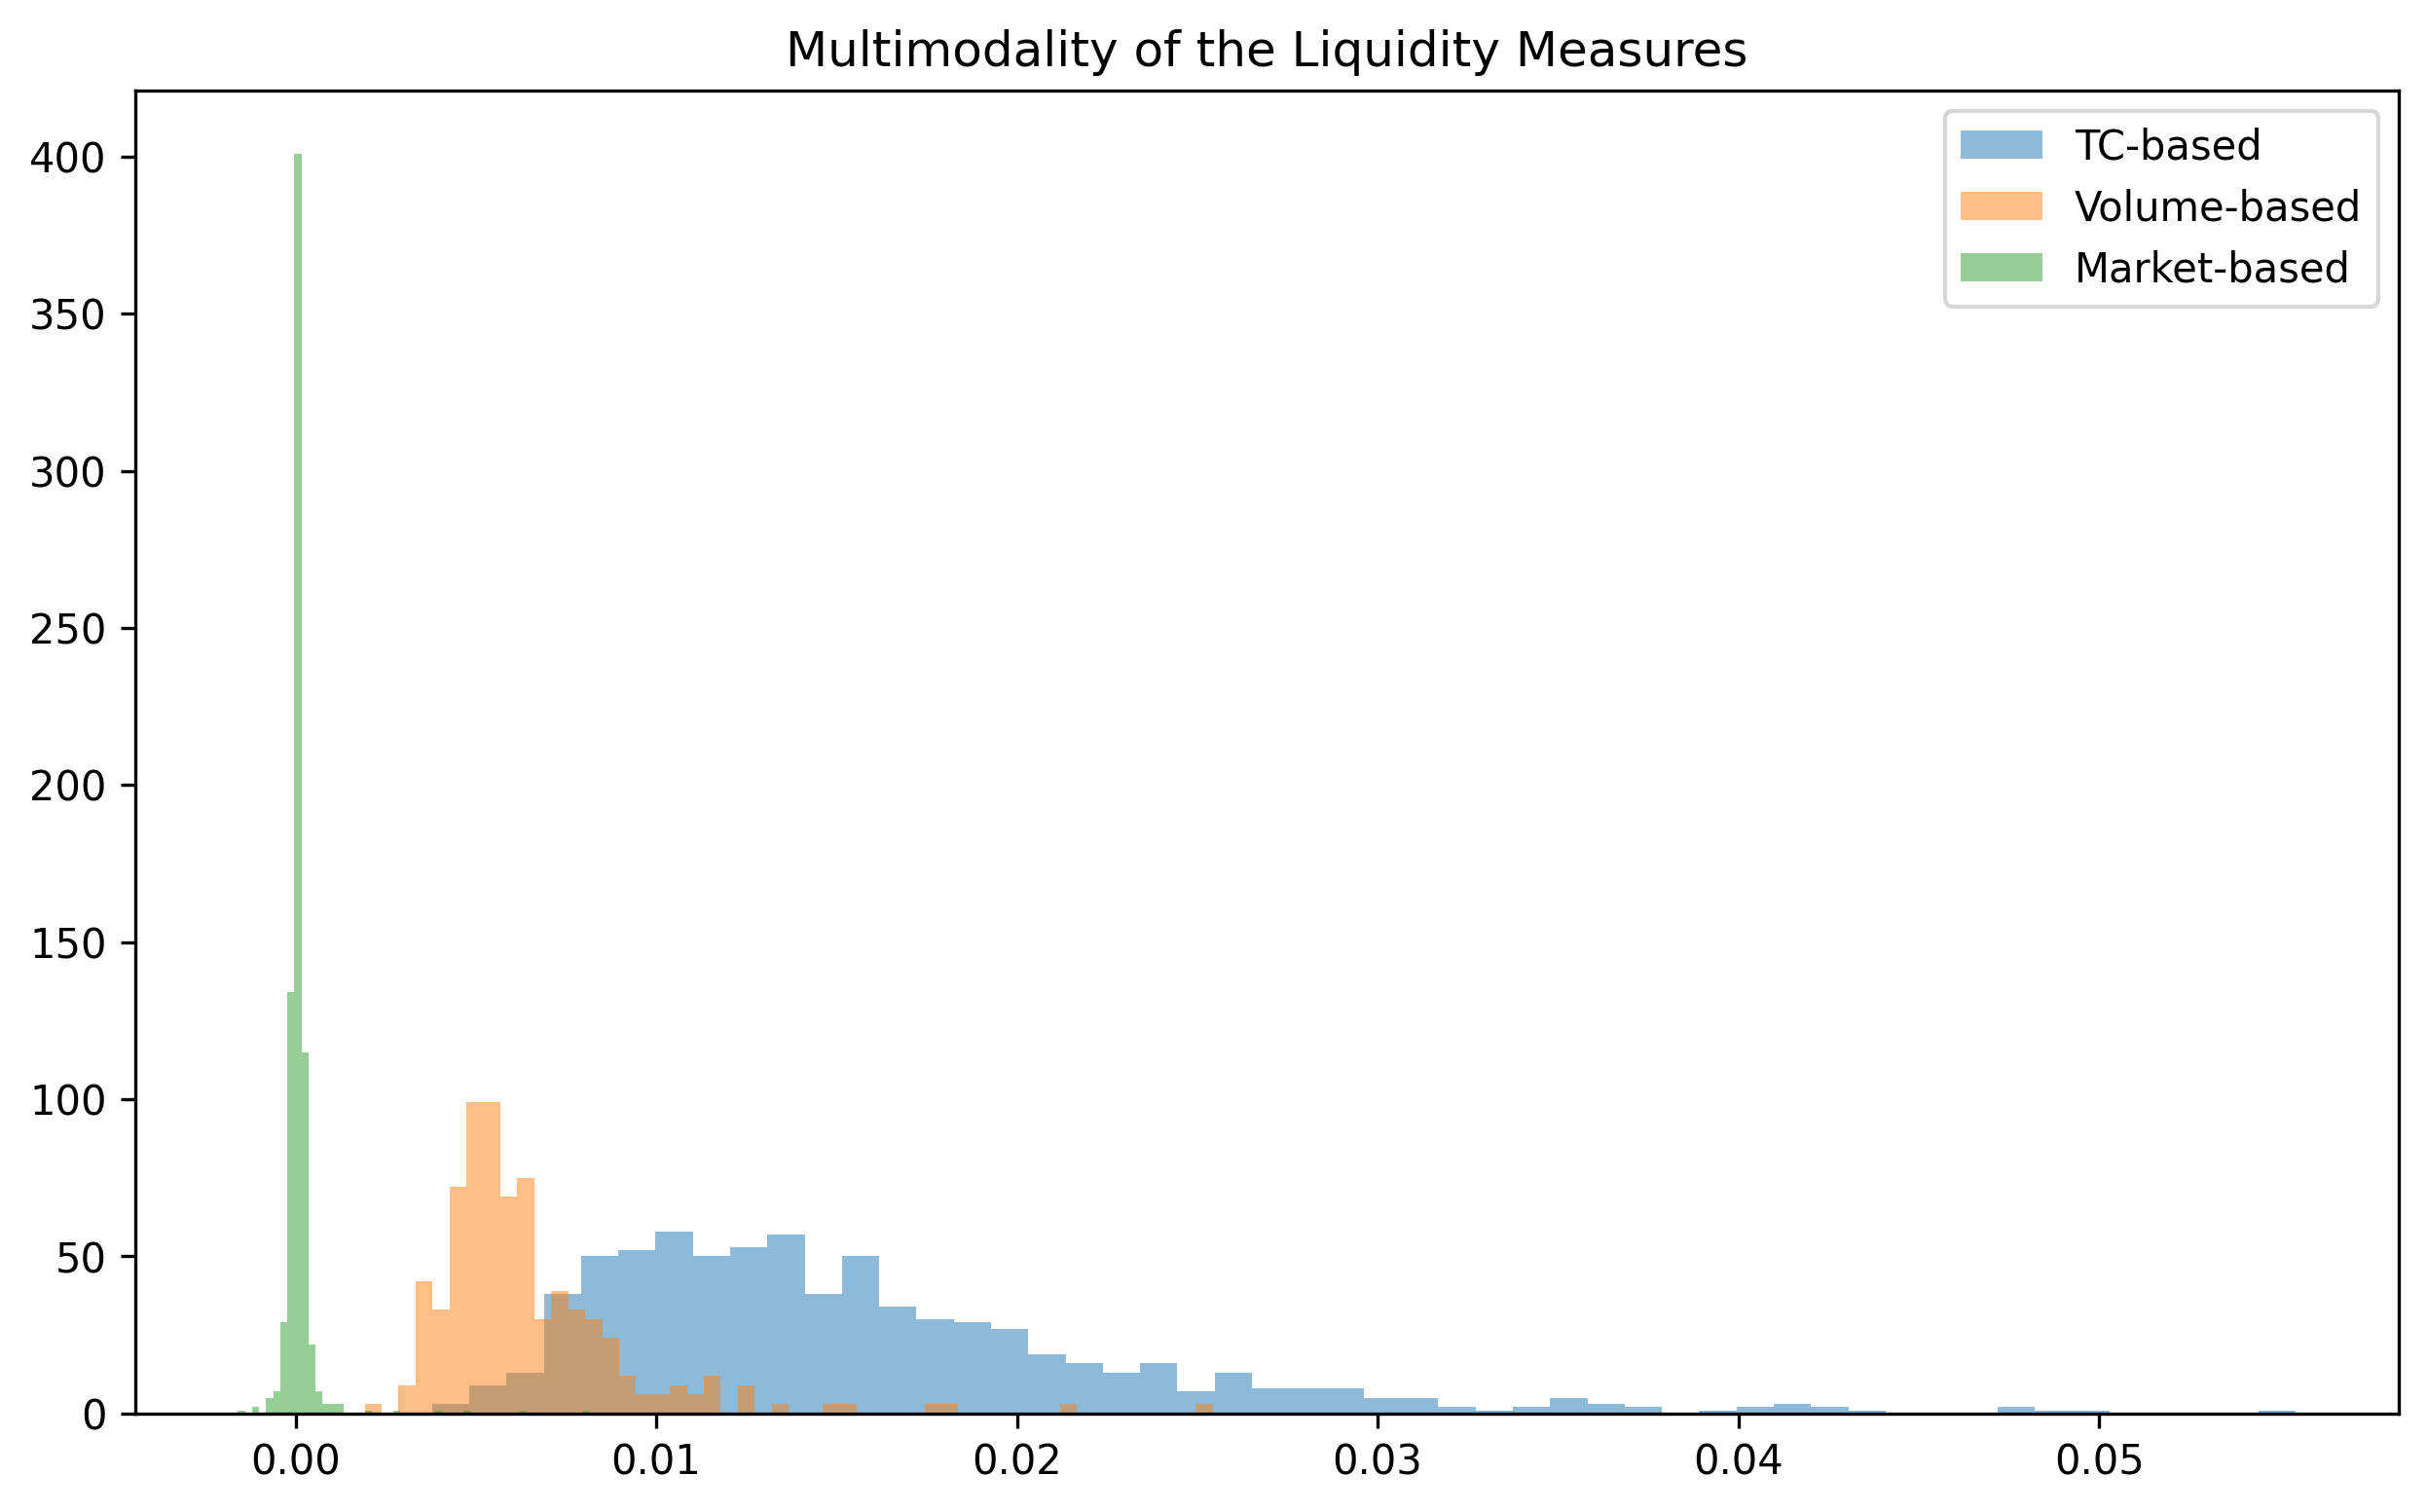

In [44]:
kwargs = dict(alpha=0.5, bins=50,  stacked=True)
plt.hist(liq_measures_all.loc[:, 'percent_quoted_ba'],
         **kwargs, label='TC-based')
plt.hist(liq_measures_all.loc[:, 'turnover_ratio'],
         **kwargs, label='Volume-based')
plt.hist(liq_measures_all.loc[:, 'market_impact'],
         **kwargs, label='Market-based')
plt.title('Multimodality of the Liquidity Measures')
plt.legend()
plt.show()

And now, given the transaction cost, volume, and market-based liquidity measures, multimodality (i.e., three peaks) can be easily observed

### Choosing the covariance type
If you look at the details of the preceding fits, you will see that the covariance_type option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation.

### How many components?

Let’s run GMM and see how we can cluster the liquidity measures. But first, a common question arises: how many clusters should we have?

One way of correcting for over-fitting to too many clusters is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

**Exercise 1**
* Generate different BIC values based on different numbers of clusters

* Draw a line plot for BIC values given number of components

* Select the number of clusters after which the the line plot seems to flatten out, making that an ideal point.

In [45]:
from sklearn.mixture import GaussianMixture

number_of_clusters = range(1,10)
bic = []

for number_cluster in number_of_clusters:
   gm = GaussianMixture(n_components=number_cluster, random_state=69).fit(scaled_liq)
   bic.append(gm.bic(scaled_liq))


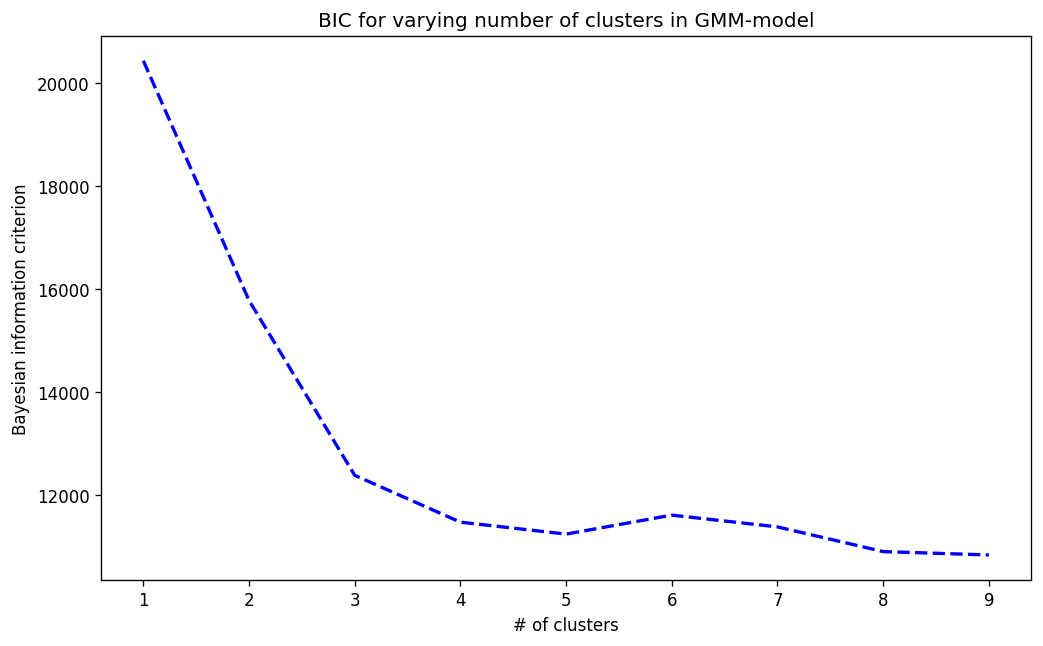

In [61]:
plt.rcParams['figure.dpi'] = 120

plt.plot(number_of_clusters, bic, linestyle="--", c="blue", linewidth = 2)
plt.title("BIC for varying number of clusters in GMM-model")
plt.xlabel("# of clusters")
plt.ylabel("Bayesian information criterion")
plt.show()

In [ ]:
# 3 or 4 seem to be a resonable amount for the numbers of clusters going forward

**Exercise 2**

In the following code block, we will try to detect the state(cluster) by which data is best represented. The term state represents nothing but the cluster with the highest posterior probability. It means that this specific state accounts for the dynamics of the data most. 


1. Configure the sklearn GMM

Specify number of clusters, how would you like to initialise the clusters and covariance type.

2. Fit GMM with scaled data

Learn the clustering

3. Run prediction for all data points

Assign each data sample to a cluster using the GMM clusters

4. Obtain the state probabilities for all datapoints

GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

5. Compute the average of state probabilities for all clusters

This gives us the state probablities

In [68]:
from sklearn.mixture import GaussianMixture

#1: 

gm = GaussianMixture(n_components=3, 
                     random_state=69)

# 2:
gm_fitted = gm.fit(scaled_liq)

# 3

predictions = gm_fitted.predict(scaled_liq)

# 4:
probas = gm_fitted.predict_proba(scaled_liq)
# probas = matrix of shape [n_samples, n_clusters]

# 5:

# average of probababilities over all clusters:
probas.mean(axis=0)

# third cluster (index 2) seems to be most probable:


array([0.15021868, 0.02439024, 0.82539108])

In [ ]:
predictions
# confirmed by this, lot of "2" in there

array([2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [65]:
# I am interested in visualizing the gausian clusters
# -> PCA dimension reduction and then plot predictions

from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='auto')

# preprocess X:

liq_pca = pca.fit_transform(scaled_liq)

liq_pca

array([[-0.26192255, -1.15978141],
       [ 0.42454118, -0.35650607],
       [-0.27448096, -2.11609059],
       ...,
       [-3.32447491,  8.61087623],
       [-1.0584776 ,  7.8170159 ],
       [-2.05232987,  7.76053541]])

In [66]:
print(scaled_liq.shape)
print(liq_pca.shape)

pca.explained_variance_ratio_

(738, 11)
(738, 2)


array([0.24520978, 0.15762229])

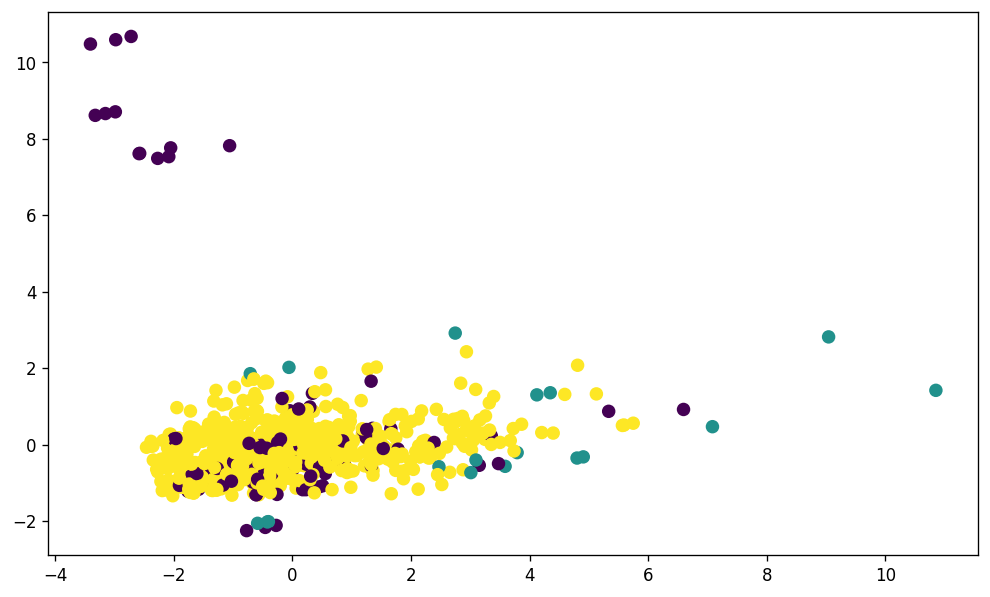

In [70]:
# simple plot
plt.scatter(liq_pca[:, 0], liq_pca[:, 1], c=predictions,
            s=50, cmap='viridis');


# do we not have enough data?
# although clustering does not seem to be too bad, since the yellow (cluster 2 with 0.85 p)
# seems to be close together in two dimensional space

# and outliers in left top are the same too!
# try with three dims?



In [71]:
pca_3dim = PCA(n_components=3, svd_solver='auto')

liq_pca_3dim = pca_3dim.fit_transform(scaled_liq)

liq_pca_3dim


array([[-0.26192255, -1.15978141,  1.16658229],
       [ 0.42454118, -0.35650607,  1.80301655],
       [-0.27448096, -2.11609059,  0.44705682],
       ...,
       [-3.32447491,  8.61087623, -1.66345942],
       [-1.0584776 ,  7.8170159 , -0.11820625],
       [-2.05232987,  7.76053541,  0.09709866]])

In [72]:
pca_3dim.explained_variance_ratio_

array([0.24520978, 0.15762229, 0.11758293])

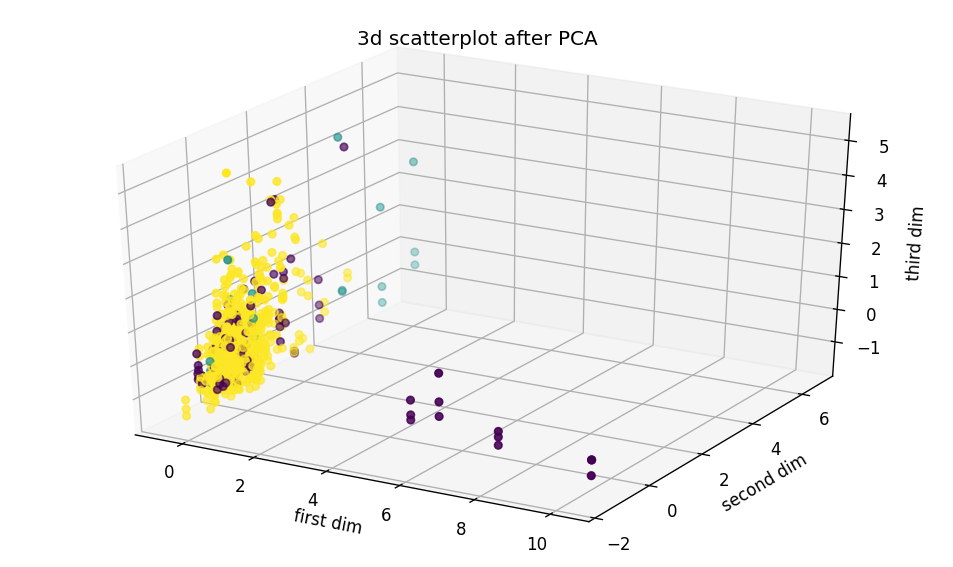

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =scaled_liq[:, 1]
y =scaled_liq[:, 2]
z =scaled_liq[:, 3]

ax.scatter(x, y, z, c=predictions, marker='o')

ax.set_xlabel('first dim')
ax.set_ylabel('second dim')
ax.set_zlabel('third dim')

plt.title("3d scatterplot after PCA")

plt.show()

In [ ]:
# as usual with real world data things are not so simple.
# our visualized clustering does not look as pretty as one would hope